# Stacking, stage 2

In [1]:
import os, sys
# sys.path.append("..")

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

import numpy as np
import torch
import torch.nn as nn
import torchvision
import gc

from src import distributions
import torch.nn.functional as F

from src.resnet2 import ResNet_D
from src.unet import UNet

from src.tools import unfreeze, freeze
from src.tools import weights_init_D
from src.tools import load_dataset, get_pushed_loader_stats
from src.fid_score import calculate_frechet_distance
from src.plotters import plot_random_images, plot_images

from src.transform_save_load import transform_data, new_sample_the_same

from copy import deepcopy
import json

from tqdm import tqdm
from IPython.display import clear_output

import wandb # <--- online logging of the results
from src.tools import fig2data, fig2img # for wandb

# This needed to use dataloaders for some datasets
from PIL import PngImagePlugin
LARGE_ENOUGH_NUMBER = 100
PngImagePlugin.MAX_TEXT_CHUNK = LARGE_ENOUGH_NUMBER * (1024**2)

## Main Config

In [2]:
STAGE = 2

DEVICE_IDS = [0]

# Always the same
DATASET2  = 'shoes'
DATASET2_PATH = 'data/shoes_64.hdf5'
# DATASET2_PATH = f'data/shoes_64_stage_{STAGE}.pt' # Not necessary

DATASET1 = 'handbag'

# Only for stage 1, before getting the prediction
# DATASET1_SOURCE_PATH = 'data/handbag_64.hdf5'

# For the next stages (STAGE > 1)
DATASET1_SOURCE_TRAIN_PATH =  f'data/handbag_64_train_stage_{STAGE-1}.pt'
DATASET1_SOURCE_TEST_PATH =  f'data/handbag_64_test_stage_{STAGE-1}.pt'

# Path for getting the best weights from last stage
BEST_WEIGHTS_PATH = f'best_weights/stage_{STAGE-1}.pt'

# Path for saving prediction images by the previous stage
# and for loading from them for the current stage
DATASET1_TRAIN_PATH = f'data/handbag_64_train_stage_{STAGE}.pt'
DATASET1_TEST_PATH = f'data/handbag_64_test_stage_{STAGE}.pt'


T_ITERS = 10
f_LR, T_LR = 1e-4, 1e-4
IMG_SIZE = 64

BATCH_SIZE = 64

PLOT_INTERVAL = 100
COST = 'mse' # Mean Squared Error
CPKT_INTERVAL = 500
MAX_STEPS = 30_001
SEED = 0x000000

EXP_NAME = f'{DATASET1}_{DATASET2}_T{T_ITERS}_{COST}_{IMG_SIZE}_S{STAGE}'
OUTPUT_PATH = f'checkpoints/{COST}/{DATASET1}_{DATASET2}_{IMG_SIZE}/stage_{STAGE}'

## Preparation

In [3]:
config = dict(
    DATASET1=DATASET1,
    DATASET2=DATASET2, 
    T_ITERS=T_ITERS,
    f_LR=f_LR, T_LR=T_LR,
    BATCH_SIZE=BATCH_SIZE
)
    
assert torch.cuda.is_available()
torch.cuda.set_device(f'cuda:{DEVICE_IDS[0]}')
torch.manual_seed(SEED); np.random.seed(SEED)

if not os.path.exists(OUTPUT_PATH):
    os.makedirs(OUTPUT_PATH)

## Loading data stats for testing

In [4]:
# Always the same
filename = 'data/{}_{}_test.json'.format(DATASET2, IMG_SIZE)
with open(filename, 'r') as fp:
    data_stats = json.load(fp)
    mu_data, sigma_data = data_stats['mu'], data_stats['sigma']
del data_stats

## Prepare Previous Samplers (Y and X)

In [5]:
# Always the same
Y_sampler, Y_test_sampler = load_dataset(DATASET2, DATASET2_PATH, img_size=IMG_SIZE)

Keys: <KeysViewHDF5 ['imgs']>


In [6]:
# Only for the stage 1
# X_sampler, X_test_sampler = load_dataset(DATASET1, 
#                             DATASET1_SOURCE_PATH, img_size=IMG_SIZE)

# For the stage 2 and next
X_sampler = new_sample_the_same(DATASET1_SOURCE_TRAIN_PATH)
X_test_sampler = new_sample_the_same(DATASET1_SOURCE_TEST_PATH)
    
torch.cuda.empty_cache(); gc.collect()
# clear_output()

0

## Set up T(X) on best weights

In [7]:
T = UNet(3, 3, base_factor=48)

# T = UNet(3, 3, base_factor=48).cuda()
# if len(DEVICE_IDS) > 1:
#     T = nn.DataParallel(T, device_ids=DEVICE_IDS)
    
print('T params:', np.sum([np.prod(p.shape) for p in T.parameters()]))

# Setup earlier params
T.load_state_dict(torch.load(BEST_WEIGHTS_PATH))

T params: 9715827


<All keys matched successfully>

## Predict on best T(X) for train and test, and save results

In [8]:
transform_data(X_sampler, DATASET1_TRAIN_PATH, T)
del X_sampler

Done!


In [9]:
transform_data(X_test_sampler, DATASET1_TEST_PATH, T)
del X_test_sampler

Done!


## Prepare New Samplers X
Y has been uploaded early

In [11]:
X_sampler = new_sample_the_same(DATASET1_TRAIN_PATH, shuffle=True)
X_test_sampler = new_sample_the_same(DATASET1_TEST_PATH)

torch.cuda.empty_cache(); gc.collect()

10

# Initializing Networks

In [12]:
f = ResNet_D(IMG_SIZE, nc=3).cuda() # f = ResNet_D(IMG_SIZE, nc=3, nfilter=128, nfilter_max=1024).cuda()
f.apply(weights_init_D)

T = UNet(3, 3, base_factor=48).cuda()

if len(DEVICE_IDS) > 1:
    T = nn.DataParallel(T, device_ids=DEVICE_IDS)
    f = nn.DataParallel(f, device_ids=DEVICE_IDS)
    
print('T params:', np.sum([np.prod(p.shape) for p in T.parameters()]))
print('f params:', np.sum([np.prod(p.shape) for p in f.parameters()]))

# Setup earlier params
# T.load_state_dict(torch.load('checkpoints\\mse\\handbag_shoes_64\\0_1999.pt'))

T params: 9715827
f params: 22933441


In [13]:
torch.manual_seed(0xBADBEEF); np.random.seed(0xBADBEEF)
X_fixed = X_sampler.sample(10)
Y_fixed = Y_sampler.sample(10)
X_test_fixed = X_test_sampler.sample(10)
Y_test_fixed = Y_test_sampler.sample(10)

### Plots Test

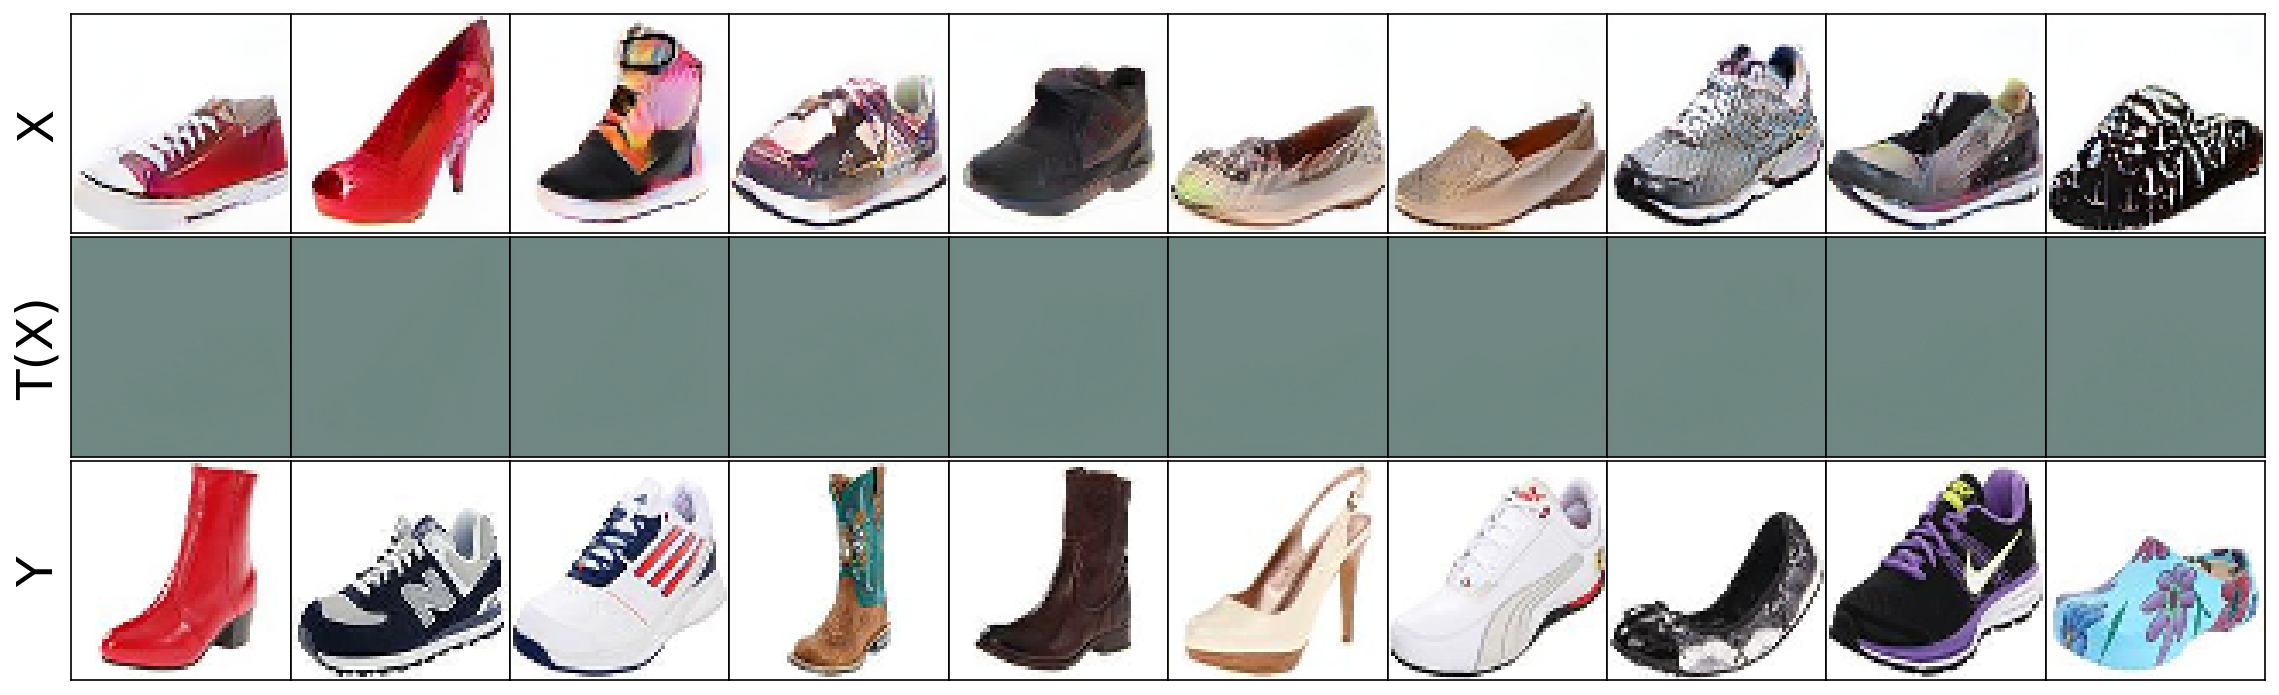

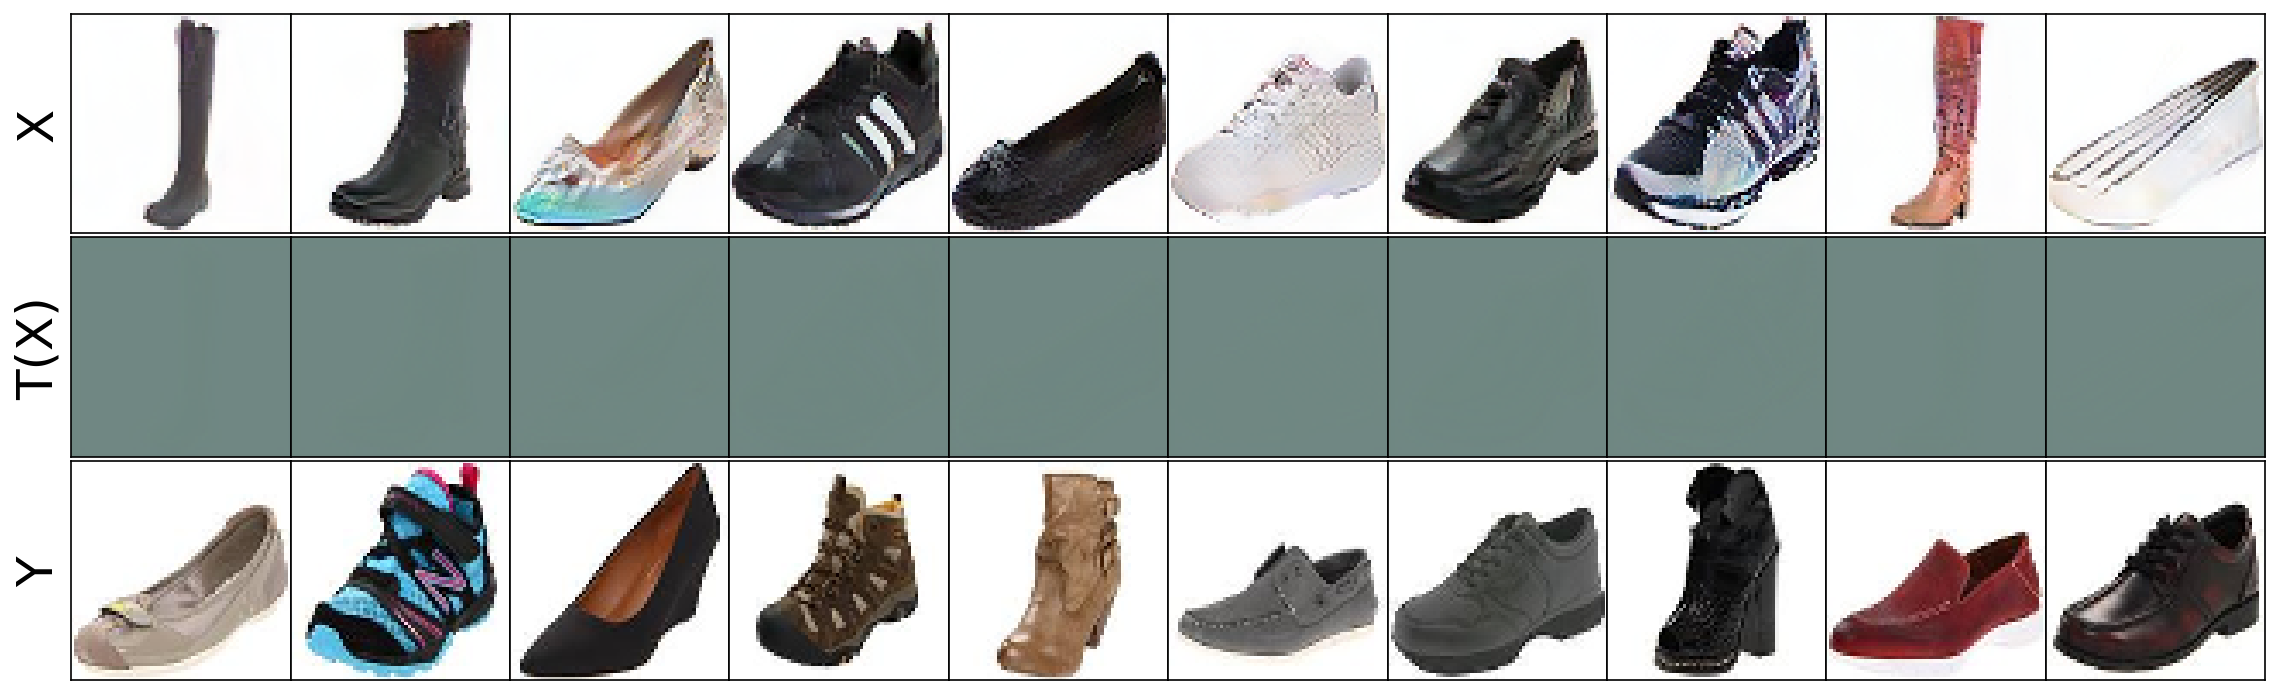

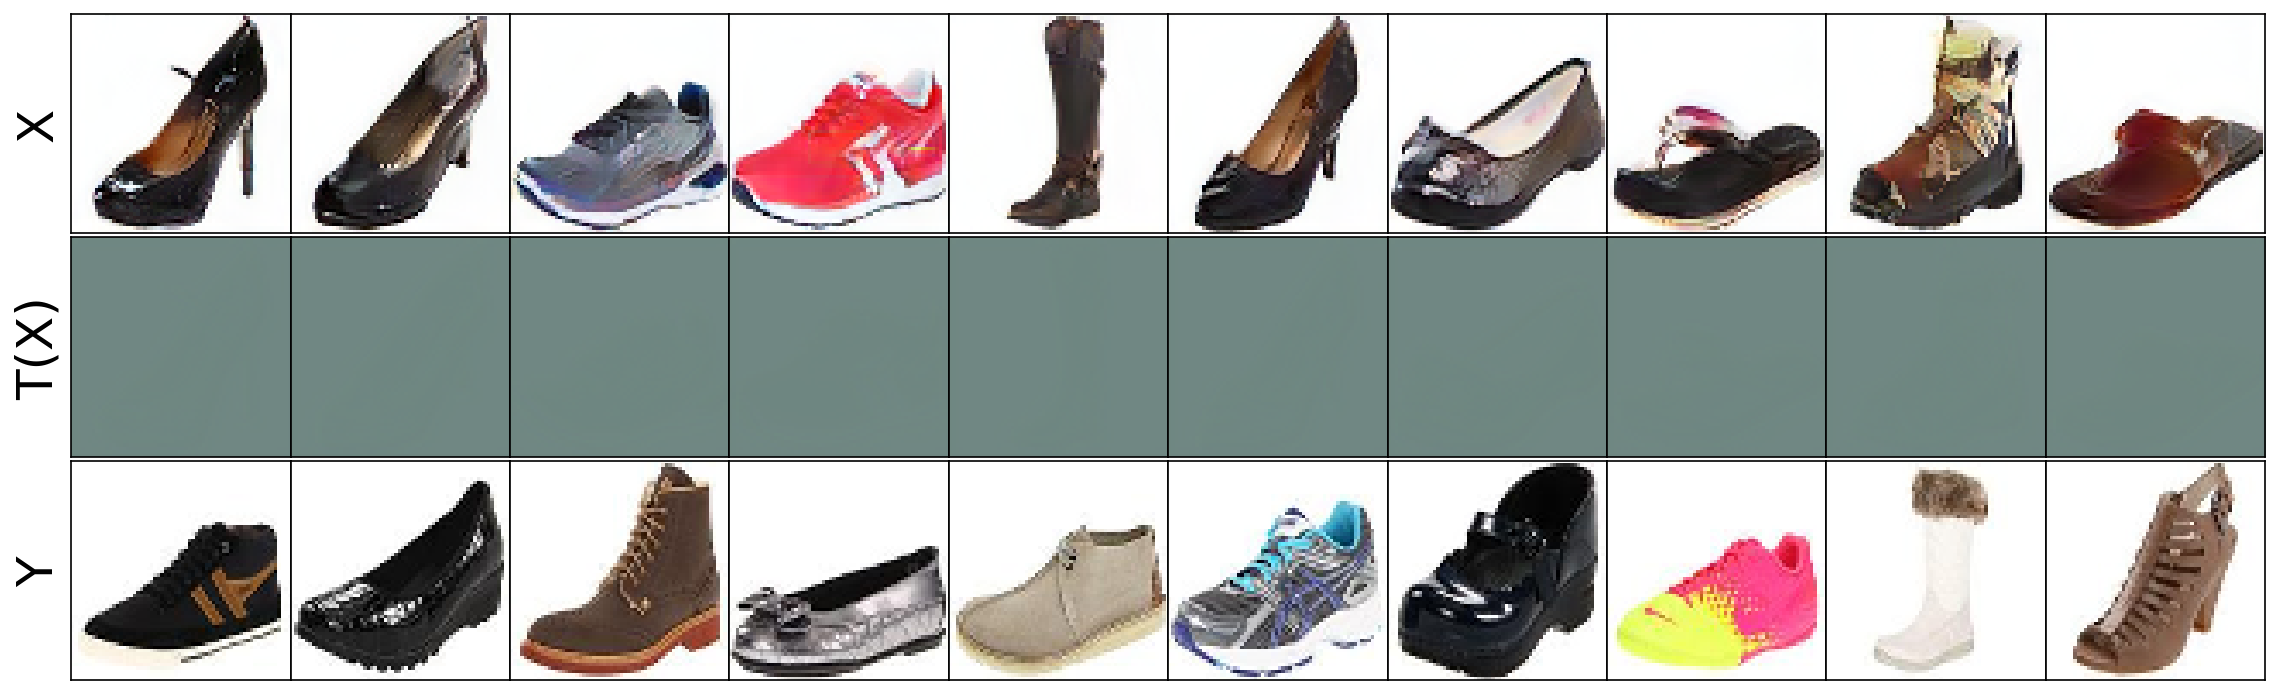

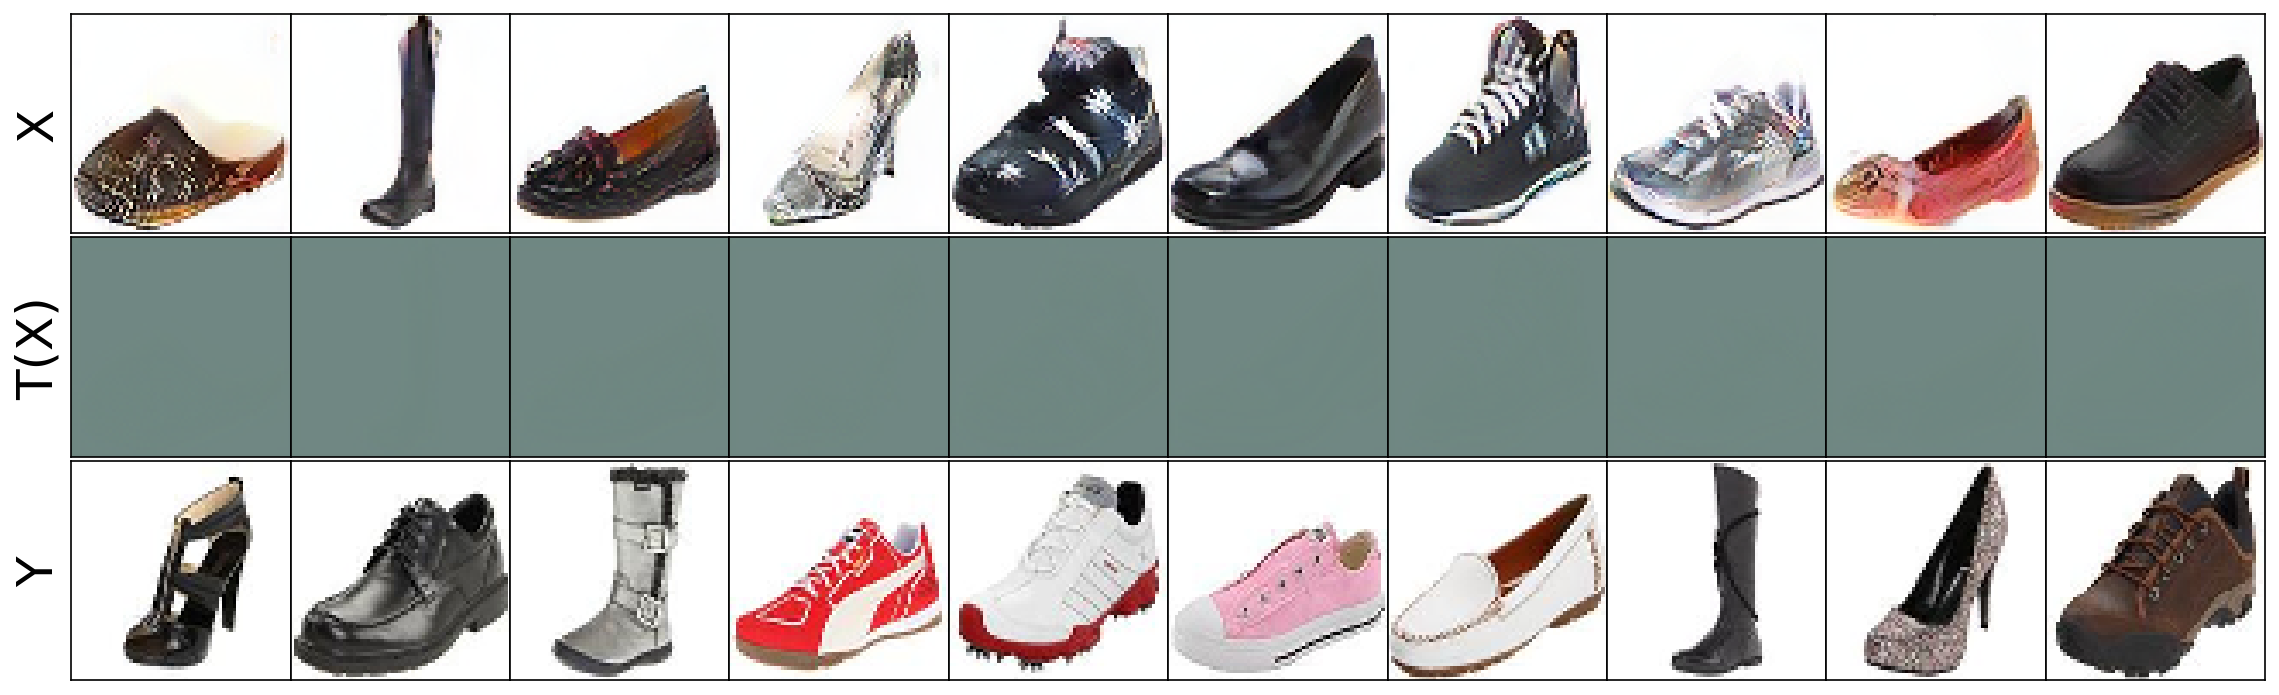

In [14]:
fig, axes = plot_images(X_fixed, Y_fixed, T)
fig, axes = plot_random_images(X_sampler, Y_sampler, T)
fig, axes = plot_images(X_test_fixed, Y_test_fixed, T)
fig, axes = plot_random_images(X_test_sampler, Y_test_sampler, T)

# Run Training

In [15]:
wandb.init(name=EXP_NAME, project='snot', entity='dstech', config=config)
pass

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: vulf (dstech). Use `wandb login --relogin` to force relogin


In [16]:
T_opt = torch.optim.Adam(T.parameters(), lr=T_LR, weight_decay=1e-10)
f_opt = torch.optim.Adam(f.parameters(), lr=f_LR, weight_decay=1e-10)

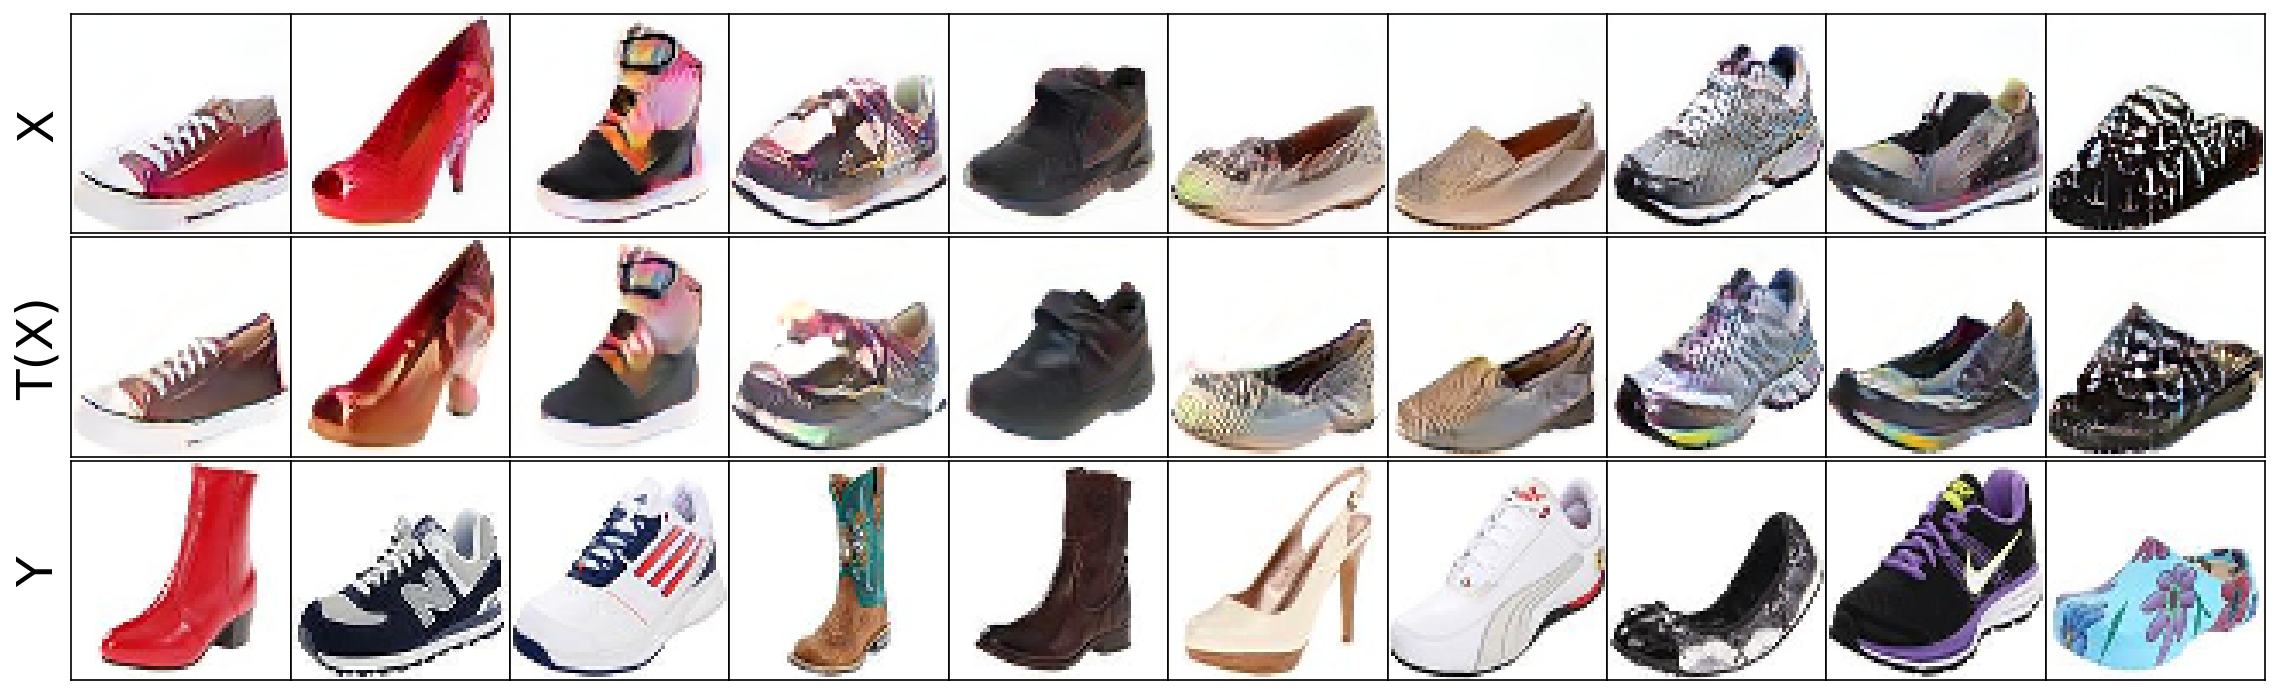

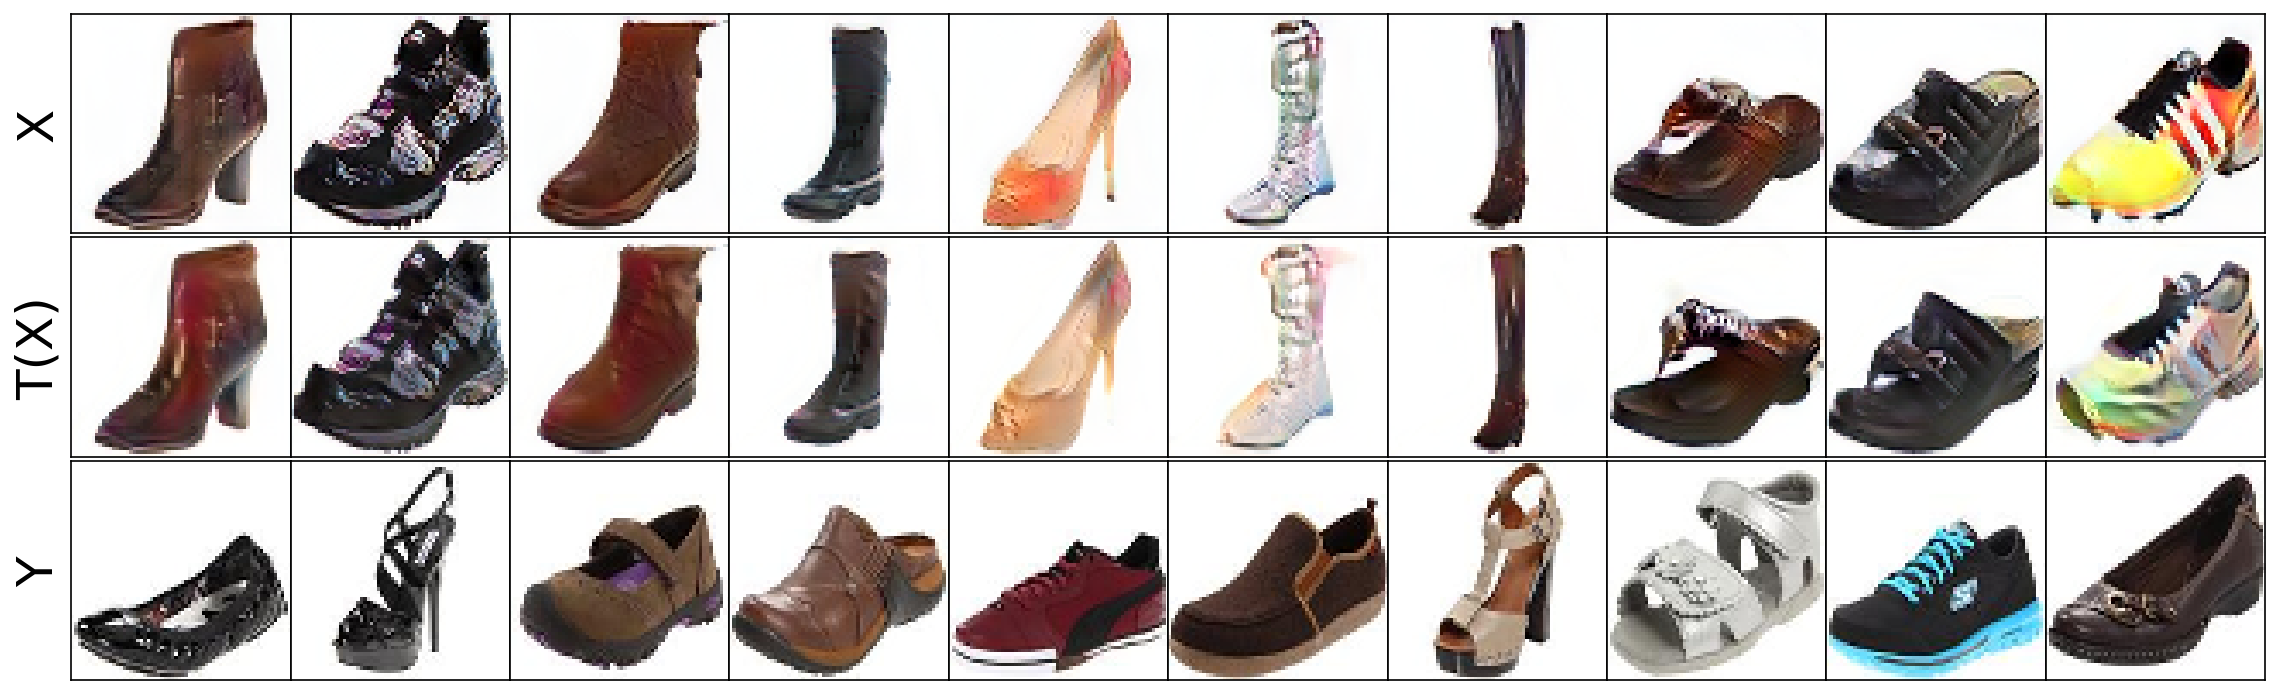

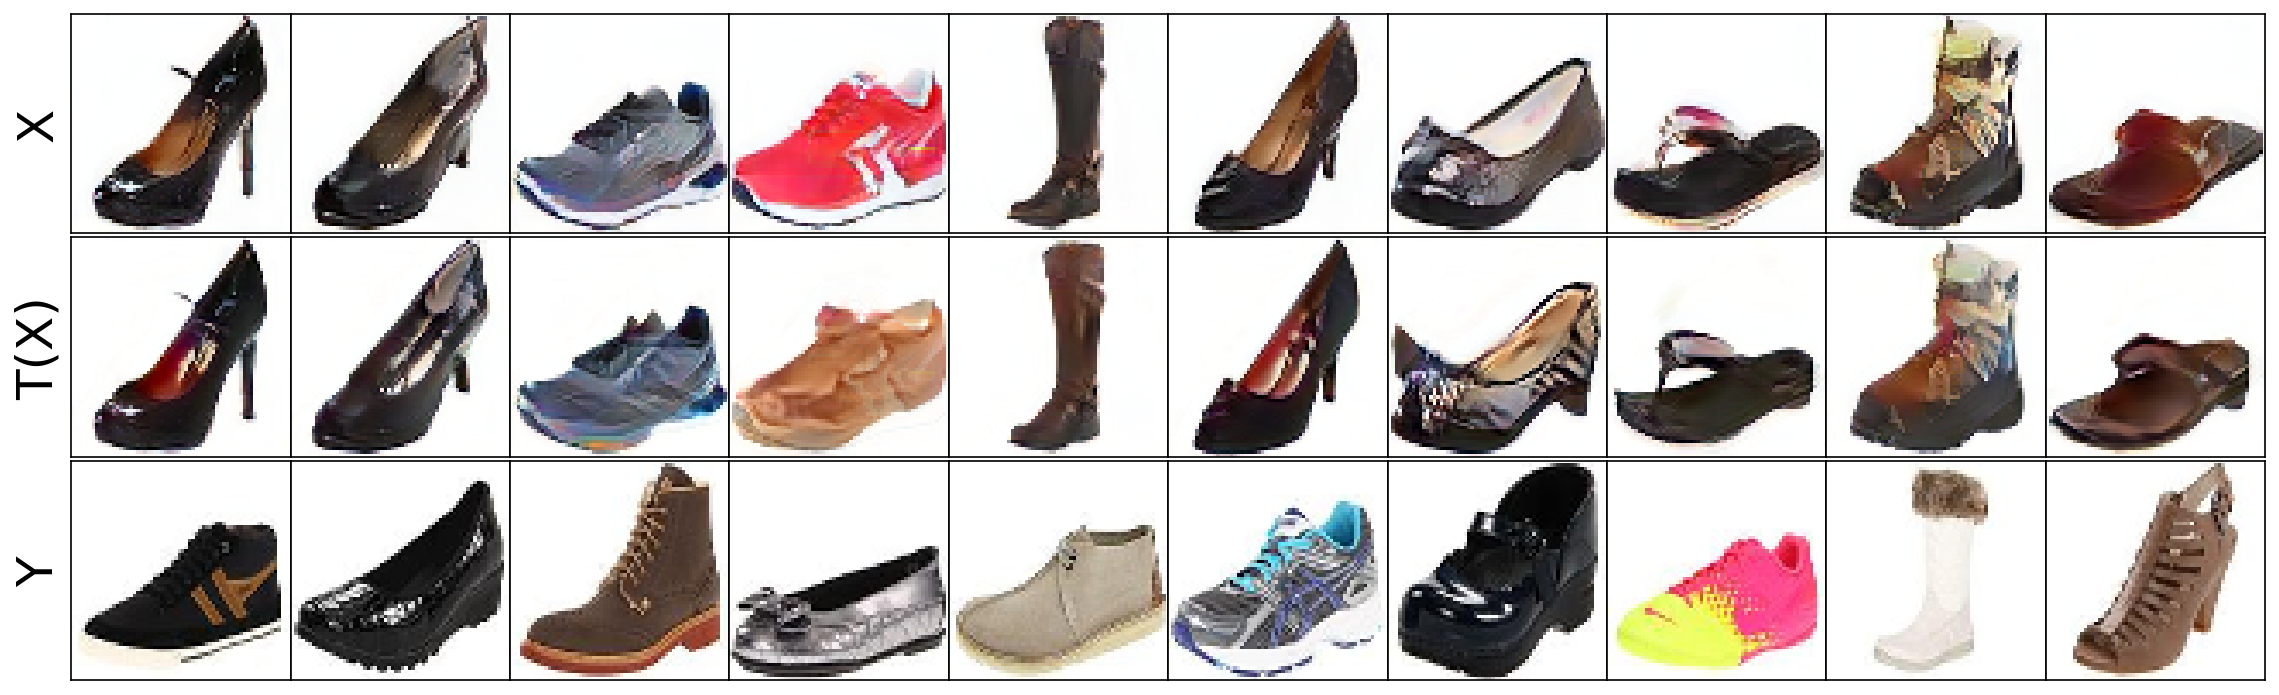

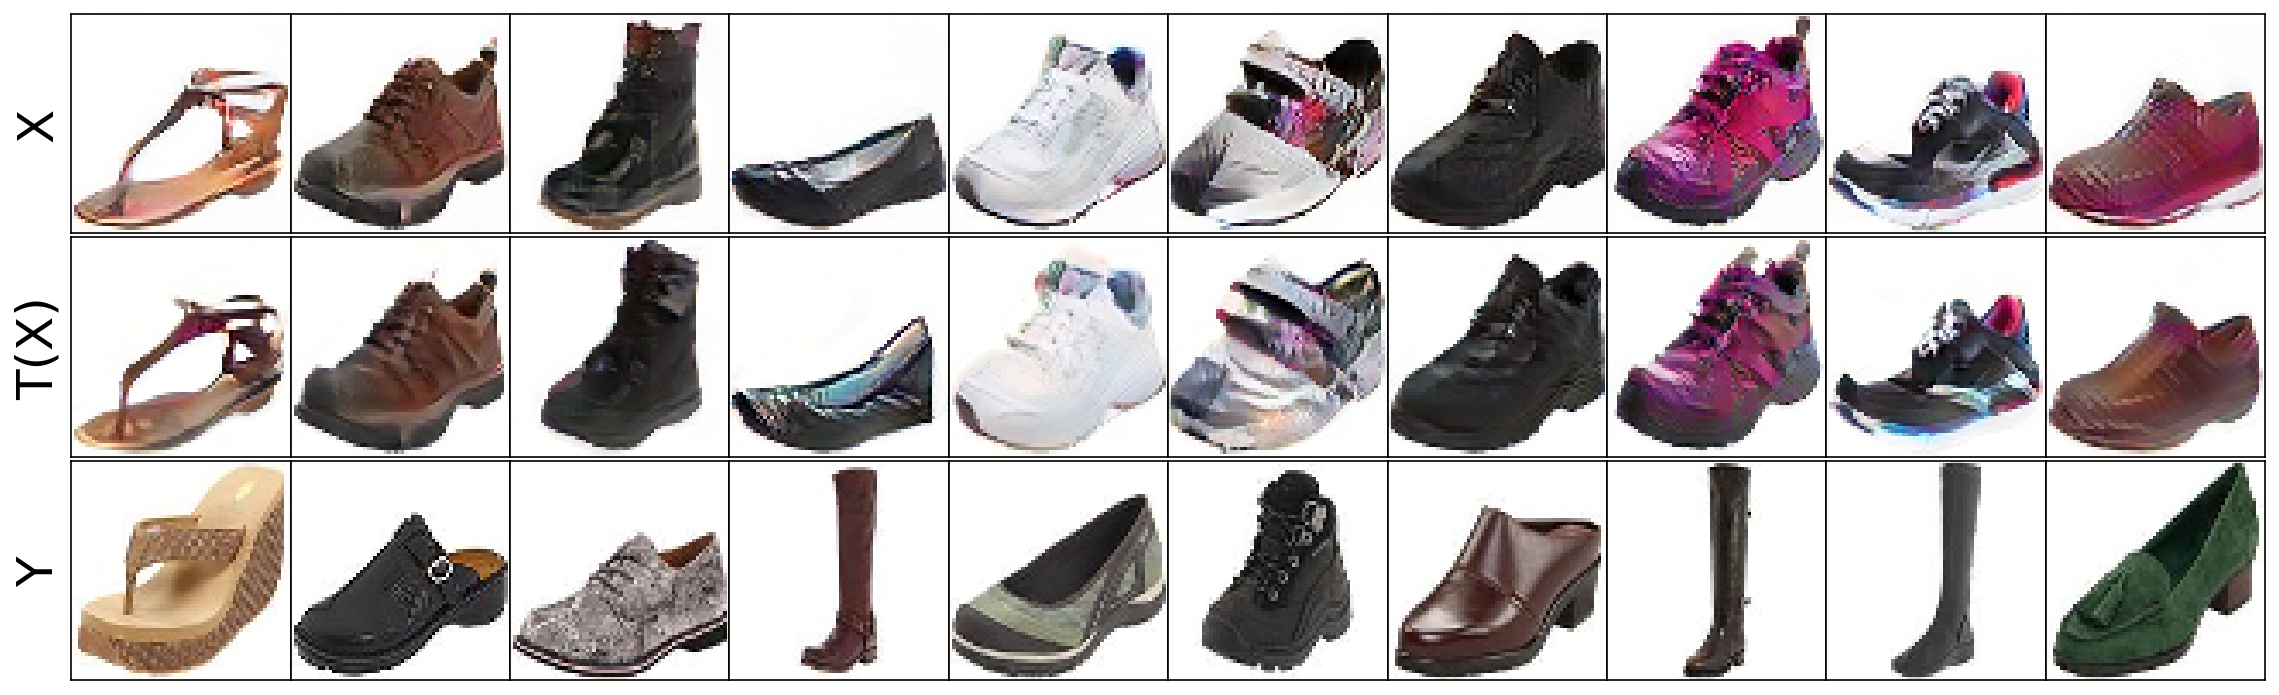

100%|██████████| 30001/30001 [23:31:08<00:00,  2.82s/it]


In [17]:
for step in tqdm(range(MAX_STEPS)):
    # T optimization
    unfreeze(T); freeze(f)
    for t_iter in range(T_ITERS): 
        T_opt.zero_grad()
        X = X_sampler.sample(BATCH_SIZE)
        T_X = T(X)
        if COST == 'mse':
            T_loss = F.mse_loss(X, T_X).mean() - f(T_X).mean()
        else:
            raise Exception('Unknown COST')
        T_loss.backward(); T_opt.step()
    del T_loss, T_X, X; gc.collect(); torch.cuda.empty_cache()

    # f optimization
    freeze(T); unfreeze(f)
    X = X_sampler.sample(BATCH_SIZE)
    with torch.no_grad():
        T_X = T(X)
    Y = Y_sampler.sample(BATCH_SIZE)
    f_opt.zero_grad()
    f_loss = f(T_X).mean() - f(Y).mean()
    f_loss.backward(); f_opt.step();
    wandb.log({f'f_loss' : f_loss.item()}, step=step) 
    del f_loss, Y, X, T_X; gc.collect(); torch.cuda.empty_cache()
        
    if step % PLOT_INTERVAL == 0:
        print('Plotting')
        clear_output(wait=True)
        
        fig, axes = plot_images(X_fixed, Y_fixed, T)
        wandb.log({'Fixed Images' : [wandb.Image(fig2img(fig))]}, step=step) 
        plt.show(fig); plt.close(fig) 
        
        fig, axes = plot_random_images(X_sampler,  Y_sampler, T)
        wandb.log({'Random Images' : [wandb.Image(fig2img(fig))]}, step=step) 
        plt.show(fig); plt.close(fig) 
        
        fig, axes = plot_images(X_test_fixed, Y_test_fixed, T)
        wandb.log({'Fixed Test Images' : [wandb.Image(fig2img(fig))]}, step=step) 
        plt.show(fig); plt.close(fig) 
        
        fig, axes = plot_random_images(X_test_sampler, Y_test_sampler, T)
        wandb.log({'Random Test Images' : [wandb.Image(fig2img(fig))]}, step=step) 
        plt.show(fig); plt.close(fig) 
    
    if step % CPKT_INTERVAL == CPKT_INTERVAL - 1:
        freeze(T); 
        
        print('Computing FID')
        mu, sigma = get_pushed_loader_stats(T, X_test_sampler.loader)
        fid = calculate_frechet_distance(mu_data, sigma_data, mu, sigma)
        wandb.log({f'FID (Test)' : fid}, step=step)
        del mu, sigma
        
        torch.save(T.state_dict(), os.path.join(OUTPUT_PATH, f'{SEED}_{step}.pt'))
        torch.save(f.state_dict(), os.path.join(OUTPUT_PATH, f'f_{SEED}_{step}.pt'))
        torch.save(f_opt.state_dict(), os.path.join(OUTPUT_PATH, f'f_opt_{SEED}_{step}.pt'))
        torch.save(T_opt.state_dict(), os.path.join(OUTPUT_PATH, f'T_opt_{SEED}_{step}.pt'))
    
    gc.collect(); torch.cuda.empty_cache()

In [18]:
# Finish experiment
gc.collect(); torch.cuda.empty_cache()
wandb.finish()

FID (Test),▂▂▂▂▂▂▆▂▂▂▂▄▂▅▅▂▁▄▁▃▃▁▃▄▁▂▄▄▃▃▄▂▃▃█▂▃▄▇▆
f_loss,▆▆▆▄▆▆▆▆▅▅█▅▆▆▆▆▅▇▅▇▅▅▅▇█▆▇▆▅▆▃▇▄▆▁▄▄▃█▂
FID (Test),24.62931
f_loss,-0.08715
